Generative Adversarial Networks, or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images. Although GAN models are capable of generating new random plausible examples for a given dataset, there is no way to control the types of images that are generated other than trying to figure out the complex relationship between the latent space input to the generator and the generated images. The
**conditional generative adversarial network**, or **cGAN** for short, is a type of GAN that involves the conditional generation of images by a generator model. Image generation can be conditional on a class label, if available, allowing the targeted generated of images of a given type.

This tutorial is divided into five parts; they are:
1. Conditional Generative Adversarial Networks
2. Fashion-MNIST Clothing Photograph Dataset
3. Unconditional GAN for Fashion-MNIST
4. Conditional GAN for Fashion-MNIST
5. Conditional Clothing Generation

## 1) Conditional Generative Adversarial Networks

A generative adversarial network, or GAN for short, is an architecture for training deep learning-based generative models. The architecture is comprised of a generator and a discriminator model. The generator model is responsible for generating new plausible examples that ideally are indistinguishable from real examples in the dataset. The discriminator model is responsible
for classifying a given image as either real (drawn from the dataset) or fake (generated). The models are trained together in a zero-sum or adversarial manner, such that improvements in the discriminator come at the cost of a reduced capability of the generator, and vice versa.

GANs are effective at image synthesis, that is, generating new examples of images for atarget dataset. Some datasets have additional information, such as a class label, and it is desirable to make use of this information. For example, the MNIST handwritten digit dataset has class labels of the corresponding integers, the CIFAR-10 small object photograph dataset has
class labels for the corresponding objects in the photographs, and the Fashion-MNIST clothing dataset has class labels for the corresponding items of clothing. There are two motivations for making use of the class label information in a GAN model.
1. Improve the GAN.
2. Targeted Image Generation.

Additional information that is correlated with the input images, such as class labels, can be used to improve the GAN. This improvement may come in the form of more stable training, faster training, and/or generated images that have better quality. Class labels can also be used for the deliberate or targeted generation of images of a given type. A limitation of a GAN model is that it may generate a random image from the domain. There is a relationship between points in the latent space to the generated images, but this relationship is complex and hard to map.  Alternately, a GAN can be trained in such a way that both the generator and the discriminator models are conditioned on the class label. This means that when the trained generator model is used as a standalone model to generate images in the domain, images of a given type, or class label, can be generated.

Generative adversarial nets can be extended to a conditional model if both the
generator and discriminator are conditioned on some extra information y. [...] We can perform the conditioning by feeding y into the both the discriminator and
generator as additional input layer.
— Conditional Generative Adversarial Nets, 2014.



For example, in the case of MNIST, specific handwritten digits can be generated, such as the number 9; in the case of CIFAR-10, specific object photographs can be generated such as frogs;
and in the case of the Fashion-MNIST dataset, specific items of clothing can be generated, such as dress. This type of model is called a Conditional Generative Adversarial Network, CGAN or cGAN for short. The cGAN was first described by Mehdi Mirza and Simon Osindero in their 2014 paper titled Conditional Generative Adversarial Nets. In the paper, the authors motivate the approach based on the desire to direct the image generation process of the generator model.

Their approach is demonstrated in the MNIST handwritten digit dataset where the class labels are one hot encoded and concatenated with the input to both the generator and discriminator models. The image below provides a summary of the model architecture.

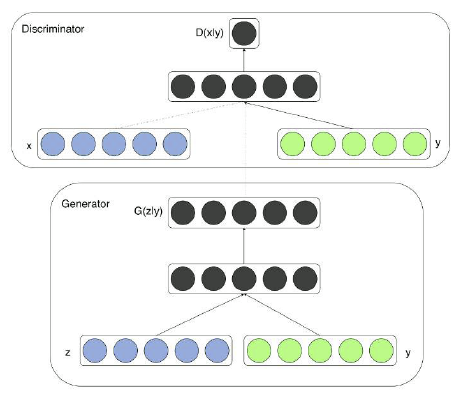

Example of a Conditional Generator and a Conditional Discriminator in a Conditional Generative Adversarial Network. Taken from Conditional Generative Adversarial Nets, 2014.

There have been many advancements in the design and training of GAN models, most notably the deep convolutional GAN, or DCGAN for short, that outlines the model configuration and training procedures that reliably result in the stable training of GAN models for a wide variety of problems. The conditional training of the DCGAN-based models may be referred to as CDCGAN or cDCGAN for short. There are many ways to encode and incorporate the class labels into the discriminator and generator models. A best practice involves using an embedding
layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map. A version of this recommendation was described in the 2015 paper titled *Deep Generative Image Models using a Laplacian Pyramid of Adversarial Networks*.

This recommendation was later added to the GAN Hacks list of heuristic recommendationswhen designing and training GAN models, summarized as:
16: Discrete variables in Conditional GANs
* Use an embedding layer
* Add as additional channels to images
* Keep embedding dimensionality low and upsample to match image channel size
— GAN Hacks, 2016.

Although GANs can be conditioned on the class label, so-called class-conditional GANs, they can also be conditioned on other inputs, such as an image, in the case where a GAN is used for image-to-image translation tasks. In this tutorial, we will develop a GAN, specifically a DCGAN, then update it to use class labels in a cGAN, specifically a cDCGAN model architecture.

## 2) Fashion-MNIST Clothing Photograph Dataset

The Fashion-MNIST dataset is proposed as a more challenging replacement dataset for the MNIST dataset. It is a dataset comprised of 60,000 small square 28 × 28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, dresses, and more. Keras provides access
to the Fashion-MNIST dataset via the fashion mnist.load dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset. The example below loads the dataset and summarizes the shape of the loaded dataset.

In [ ]:
!mkdir output
output_dir = "output" + "/"
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Mounted at /content/drive


In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print("Train", trainX.shape, trainy.shape)
print("Test", testX.shape, testy.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


the images are easier to review when we reverse the colors and plot the
background as white and the clothing in black. They are easier to view as most of the image is now white with the area of interest in black. This can be achieved using a reverse grayscale color map, as follows:


```
...
# plot raw pixel data
pyplot.imshow(trainX[i], cmap="gray_r")
```



The code below plots the first 100 images from the training dataset in a 10 by 10 square.

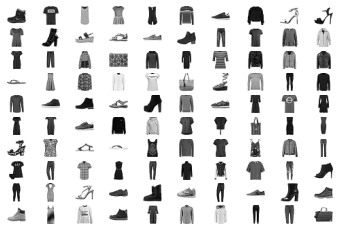

In [ ]:
# example of loading the fashion_mnist dataset
from keras.datasets.fashion_mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(100):
  # define subplot
  pyplot.subplot(10, 10, 1 + i)
  # turn off axis
  pyplot.axis("off")
  # plot raw pixel data
  pyplot.imshow(trainX[i], cmap="gray_r")

pyplot.show()

We will use the images in the training dataset as the basis for training a Generative Adversarial Network. Specifically, the generator model will learn how to generate new plausible items of clothing using a discriminator that will try to distinguish between real images from the Fashion-MNIST training dataset and new images output by the generator model. This is a relatively simple problem that does not require a sophisticated generator or discriminator model, although it does require the generation of a grayscale output image.

## 3) Unconditional GAN for Fashion-MNIST

In this section, we will develop an unconditional GAN for the Fashion-MNIST dataset. The first step is to define the models. The discriminator model takes as input one 28 × 28 grayscale image and outputs a binary prediction as to whether the image is real (class = 1) or fake
(class = 0). It is implemented as a modest convolutional neural network using best practices for GAN design such as using the LeakyReLU activation function with a slope of 0.2, using a 2 × 2 stride to downsample, and the adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5 The define discriminator() function below implements this, defining and compiling the discriminator model and returning it. The input shape of the
image is parameterized as a default function argument in case you want to re-use the function for your own image data later.

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
  model = Sequential()
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same", input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  # downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model

The generator model takes as input a point in the latent space and outputs a single 28 × 28 grayscale image. This is achieved by using a fully connected layer to interpret the point in the latent space and provide sufficient activations that can be reshaped into many copies (in this case 128) of a low-resolution version of the output image (e.g. 7 × 7). This is then upsampled
twice, doubling the size and quadrupling the area of the activations each time using transpose convolutional layers. The model uses best practices such as the LeakyReLU activation, a kernel size that is a factor of the stride size, and a hyperbolic tangent (Tanh) activation function in the output layer.

The define_generator() function below defines the generator model, but intentionally does not compile it as it is not trained directly, then returns the model. The size of the latent space is parameterized as a function argument.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # generate
  model.add(Conv2D(1, (7,7), activation="tanh", padding="same"))
  return model

Next, a GAN model can be defined that combines both the generator model and the
discriminator model into one larger model. This larger model will be used to train the model weights in the generator, using the output and error calculated by the discriminator model. The
discriminator model is trained separately, and as such, the model weights are marked as not trainable in this larger GAN model to ensure that only the weights of the generator model are updated. This change to the trainability of the discriminator weights only has an effect when training the combined GAN model, not when training the discriminator standalone.

This larger GAN model takes as input a point in the latent space, uses the generator model to generate an image which is fed as input to the discriminator model, then is output or classified as real or fake. The define_gan() function below implements this, taking the already-defined generator and discriminator models as input.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
  # make weights in the discriminator not trainable
  discriminator.trainable = False
  # connect them
  model = Sequential()
  # add generator
  model.add(generator)
  # add the discriminator
  model.add(discriminator)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

Now that we have defined the GAN model, we need to train it. But, before we can train the model, we require input data. The first step is to load and prepare the Fashion-MNIST dataset.  We only require the images in the training dataset. The images are black and white, therefore we must add an additional channel dimension to transform them to be three dimensional, as expected by the convolutional layers of our models. Finally, the pixel values must be scaled to the range [-1,1] to match the output of the generator model. The load real samples() function below implements this, returning the loaded and scaled Fashion-MNIST training dataset ready for modeling.

In [ ]:
# load fashion mnist images
def load_real_samples():
  # load dataset
  (trainX, _), (_, _) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype("float32")
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X

We will require one batch (or a half batch) of real images from the dataset each update to the GAN model. A simple way to achieve this is to select a random sample of images from the dataset each time. The generate real samples() function below implements this, taking the prepared dataset as an argument, selecting and returning a random sample of Fashion-MNIST images and their corresponding class label for the discriminator, specifically class = 1, indicating
that they are real images.

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
  # select images
  X = dataset[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return X, y

Next, we need inputs for the generator model. These are random points from the latent space, specifically Gaussian distributed random variables. The ***generate_ latent_points()*** function implements this, taking the size of the latent space as an argument and the number of points required and returning them as a batch of input samples for the generator model.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

Next, we need to use the points in the latent space as input to the generator in order to generate new images. The ***generate_fake_samples()*** function below implements this, taking the generator model and size of the latent space as arguments, then generating points in the latent space and using them as input to the generator model. The function returns the generated images and their corresponding class label for the discriminator model, specifically class = 0 to indicate they are fake or generated.

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = generator.predict(x_input)
  # create class labels
  y = zeros((n_samples, 1))
  return X, y

We are now ready to fit the GAN models. The model is fit for 100 training epochs, which is arbitrary, as the model begins generating plausible items of clothing after perhaps 20 epochs. A batch size of 128 samples is used, and each training epoch involves 60000/128 , or about 468 batches of real and fake samples and updates to the model. First, the discriminator model is updated
for a half batch of real samples, then a half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the composite GAN model. Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward getting better at generating real samples on the next batch. The ***train()*** function
below implements this, taking the defined models, dataset, and size of the latent dimension as arguments and parameterizing the number of epochs and batch size with default arguments. The generator model is saved at the end of training.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected "real" samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      # generate "fake" examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print(">%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f" % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save(output_dir + "generator.h5")

We can then define the size of the latent space, define all three models, and train them on the loaded Fashion-MNIST dataset.

In [ ]:
%%time 
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

>1, 1/468, d1=0.684, d2=0.695 g=0.692
>1, 2/468, d1=0.625, d2=0.698 g=0.689
>1, 3/468, d1=0.571, d2=0.701 g=0.687
>1, 4/468, d1=0.526, d2=0.706 g=0.684
>1, 5/468, d1=0.471, d2=0.709 g=0.682
>1, 6/468, d1=0.424, d2=0.715 g=0.679
>1, 7/468, d1=0.371, d2=0.725 g=0.676
>1, 8/468, d1=0.328, d2=0.736 g=0.670
>1, 9/468, d1=0.274, d2=0.760 g=0.666
>1, 10/468, d1=0.254, d2=0.772 g=0.667
>1, 11/468, d1=0.238, d2=0.776 g=0.674
>1, 12/468, d1=0.233, d2=0.778 g=0.693
>1, 13/468, d1=0.233, d2=0.756 g=0.731
>1, 14/468, d1=0.259, d2=0.696 g=0.794
>1, 15/468, d1=0.275, d2=0.665 g=0.828
>1, 16/468, d1=0.297, d2=0.654 g=0.801
>1, 17/468, d1=0.299, d2=0.704 g=0.742
>1, 18/468, d1=0.265, d2=0.785 g=0.662
>1, 19/468, d1=0.301, d2=0.892 g=0.581
>1, 20/468, d1=0.228, d2=0.966 g=0.548
>1, 21/468, d1=0.268, d2=0.965 g=0.566
>1, 22/468, d1=0.220, d2=0.890 g=0.614
>1, 23/468, d1=0.185, d2=0.806 g=0.677
>1, 24/468, d1=0.200, d2=0.726 g=0.752
>1, 25/468, d1=0.135, d2=0.651 g=0.832
>1, 26/468, d1=0.106, d2=0.601 g=0

**Note**: Running the example may take many hours to run on CPU hardware. Recommend running the example on GPU hardware if possible.

The loss for the discriminator on real and fake samples, as well as the loss for the generator, is reported after each batch.

Note: Your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, the discriminator and generator loss both sit around values of about 0.6 to 0.7 over the course of training.



At the end of training, the generator model will be saved to file with the filename generator.h5.

This model can be loaded and used to generate new random but plausible samples from the Fashion-MNIST dataset. The example below loads the saved model and generates 100 random items of clothing.

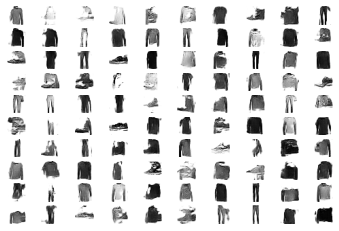

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
  
  pyplot.show()

# load model
model = load_model(output_dir + "generator.h5")
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)

Running the example creates a plot of 100 randomly generated items of clothing arranged into a 10 × 10 grid.

**Note**: Your specific results may vary given the stochastic nature of the learning algorithm.
Consider running the example a few times and compare the average performance.

In this case, we can see an assortment of clothing items such as shoes, sweaters, and pants. Most items look quite plausible and could have come from the Fashion-MNIST dataset. They are not perfect, however, as there are some sweaters with a single sleeve and shoes that look like a mess.



## 4) Conditional GAN for Fashion-MNIST

In this section, we will develop a conditional GAN for the Fashion-MNIST dataset by updating the unconditional GAN developed in the previous section. The best way to design models in Keras to have multiple inputs is by using the Functional API, as opposed to the Sequential API used in the previous section. We will use the functional API to re-implement the discriminator, generator, and the composite model. Starting with the discriminator model, a new second input is defined that takes an integer for the class label of the image. This has the effect of making the input image conditional on the provided class label.

The class label is then passed through an Embedding layer with the size of 50. This means that each of the 10 classes for the Fashion-MNIST dataset (0 through 9) will map to a different 50-element vector representation that will be learned by the discriminator model. The output of the embedding is then passed to a fully connected layer with a linear activation. Importantly, the fully connected layer has enough activations that can be reshaped into one channel of a 28×28 image. The activations are reshaped into single 28×28 activation map and concatenated with the input image. This has the effect of looking like a two-channel input image to the next convolutional layer. The define discriminator() below implements this update to the discriminator model. The parameterized shape of the input image is also used after the embedding layer to define the number of activations for the fully connected layer to reshape its
output. The number of classes in the problem is also parameterized in the function and set.

In [ ]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.utils.vis_utils import plot_model

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding="same")(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding="same")(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation="sigmoid")(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
  return model

In order to make the architecture clear, below is a plot of the discriminator model. The plot shows the two inputs: first the class label that passes through the embedding (left) and the image (right), and their concatenation into a two-channel 28×28 image or feature map (middle). The rest of the model is the same as the discriminator designed in the previous section.

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 784)       39984       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________________

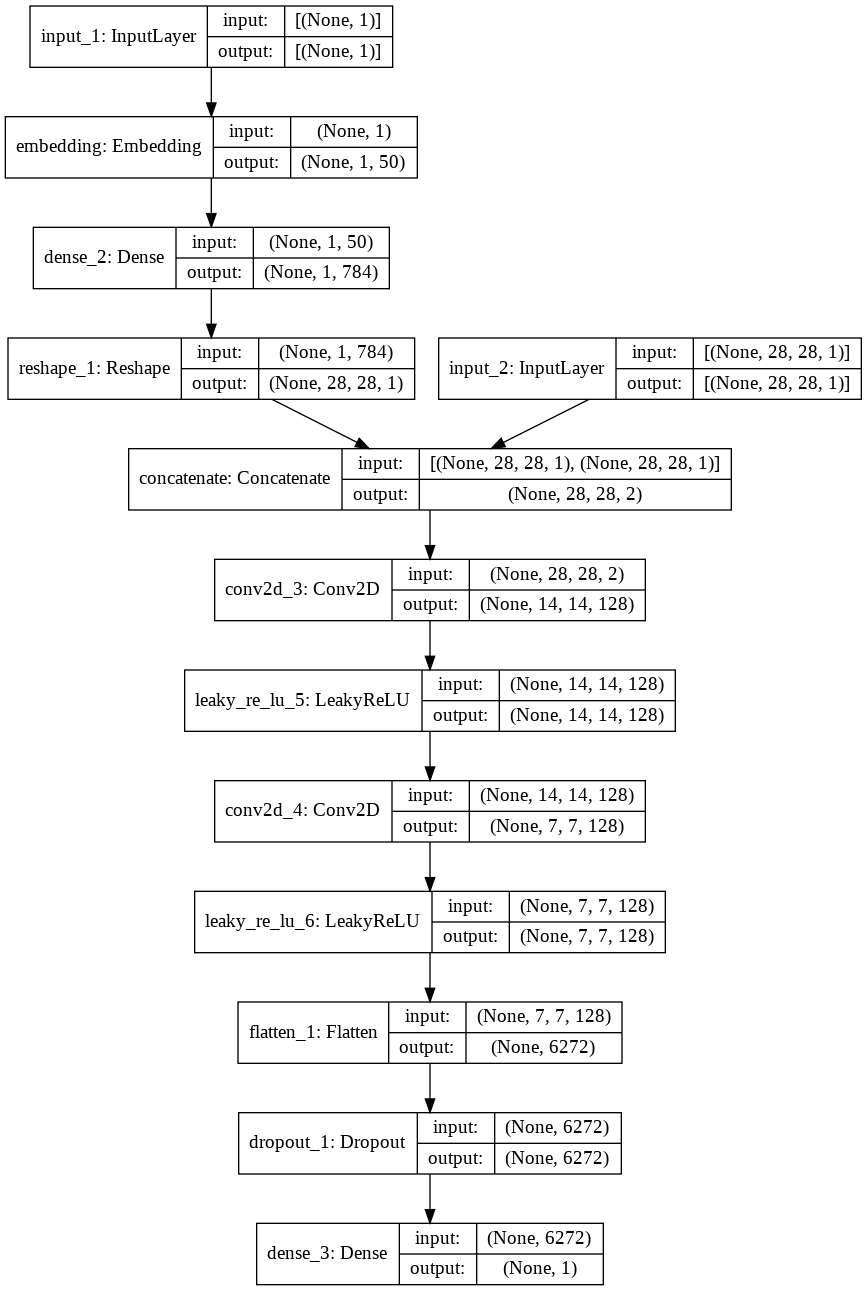

In [ ]:
discriminator_model = define_discriminator()
# summarize disriminator model
discriminator_model.summary()
# plot disriminator model
plot_model(discriminator_model, to_file=output_dir + "discriminator_model_plot.png", show_shapes=True, show_layer_names=True)

Next, the generator model must be updated to take the class label. This has the effect of making the point in the latent space conditional on the provided class label. As in the discriminator, the class label is passed through an embedding layer to map it to a unique 50-element vector and is then passed through a fully connected layer with a linear activation before being resized. In this case, the activations of the fully connected layer are resized into a single 7 × 7 feature map. This is to match the 7 × 7 feature map activations of the unconditional generator model. The new 7 × 7 feature map is added as one more channel to the existing 128, resulting in 129 feature maps that are then upsampled as in the prior model.  The define generator() function below implements this, again parameterizing the number of classes as we did with the discriminator model.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding="same")(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation="tanh", padding="same")(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model

To help understand the new model architecture, the image below provides a plot of the new conditional generator model. In this case, you can see the 100-element point in latent space as input and subsequent resizing (left) and the new class label input and embedding layer (right), then the concatenation of the two sets of feature maps (center). The remainder of the model is the same as the unconditional case.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

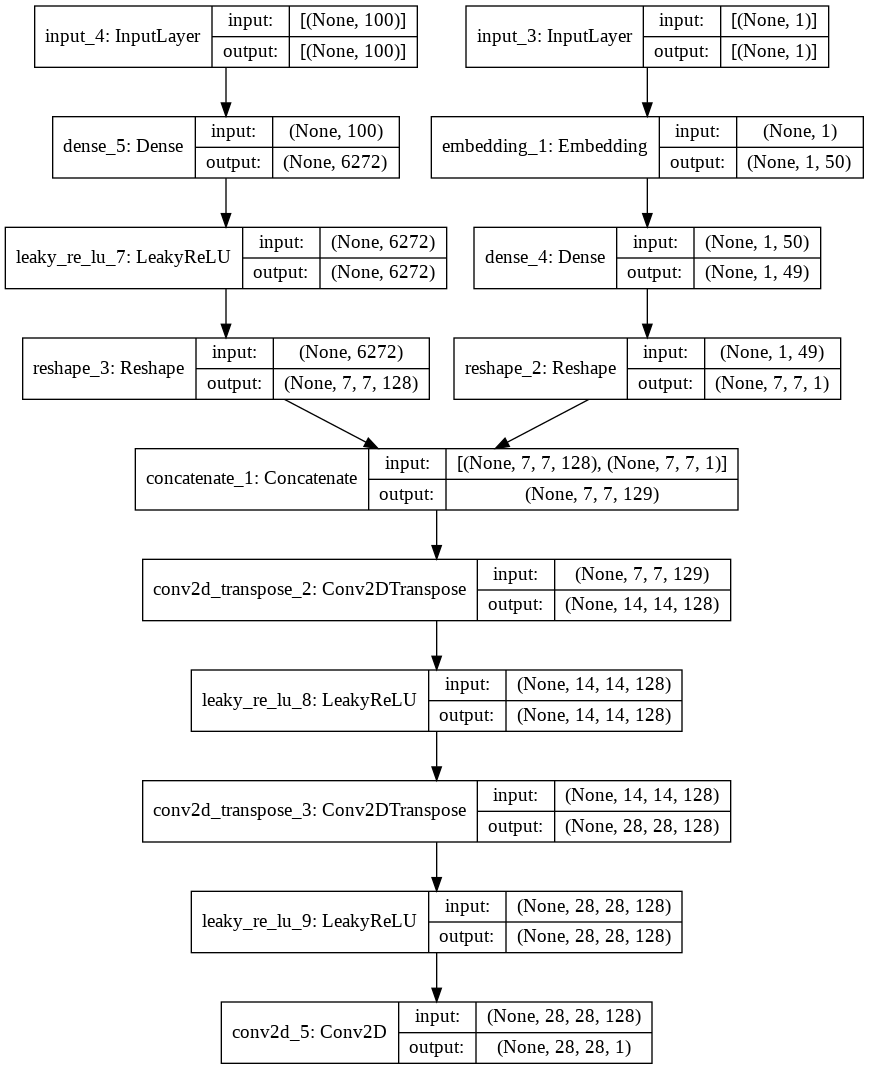

In [ ]:
generator_model = define_generator(100)
# summarize generator model
generator.summary()
# plot generator model
plot_model(generator_model, to_file=output_dir + "generator_model_plot.png", show_shapes=True, show_layer_names=True)

Finally, the composite GAN model requires updating. The new GAN model will take a point in latent space as input and a class label and generate a prediction of whether input was real or fake, as before. Using the functional API to design the model, it is important that we explicitly connect the image generated output from the generator as well as the class label input, both as input to the discriminator model. This allows the same class label input to flow down into the generator and down into the discriminator. The define gan() function below implements the conditional version of the GAN.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # get image output from the generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

The plot below summarizes the composite GAN model. Importantly, it shows the generator model in full with the point in latent space and class label as input, and the connection of the output of the generator and the same class label as input to the discriminator model (last box at the bottom of the plot) and the output of a single class label classification of real or fake.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

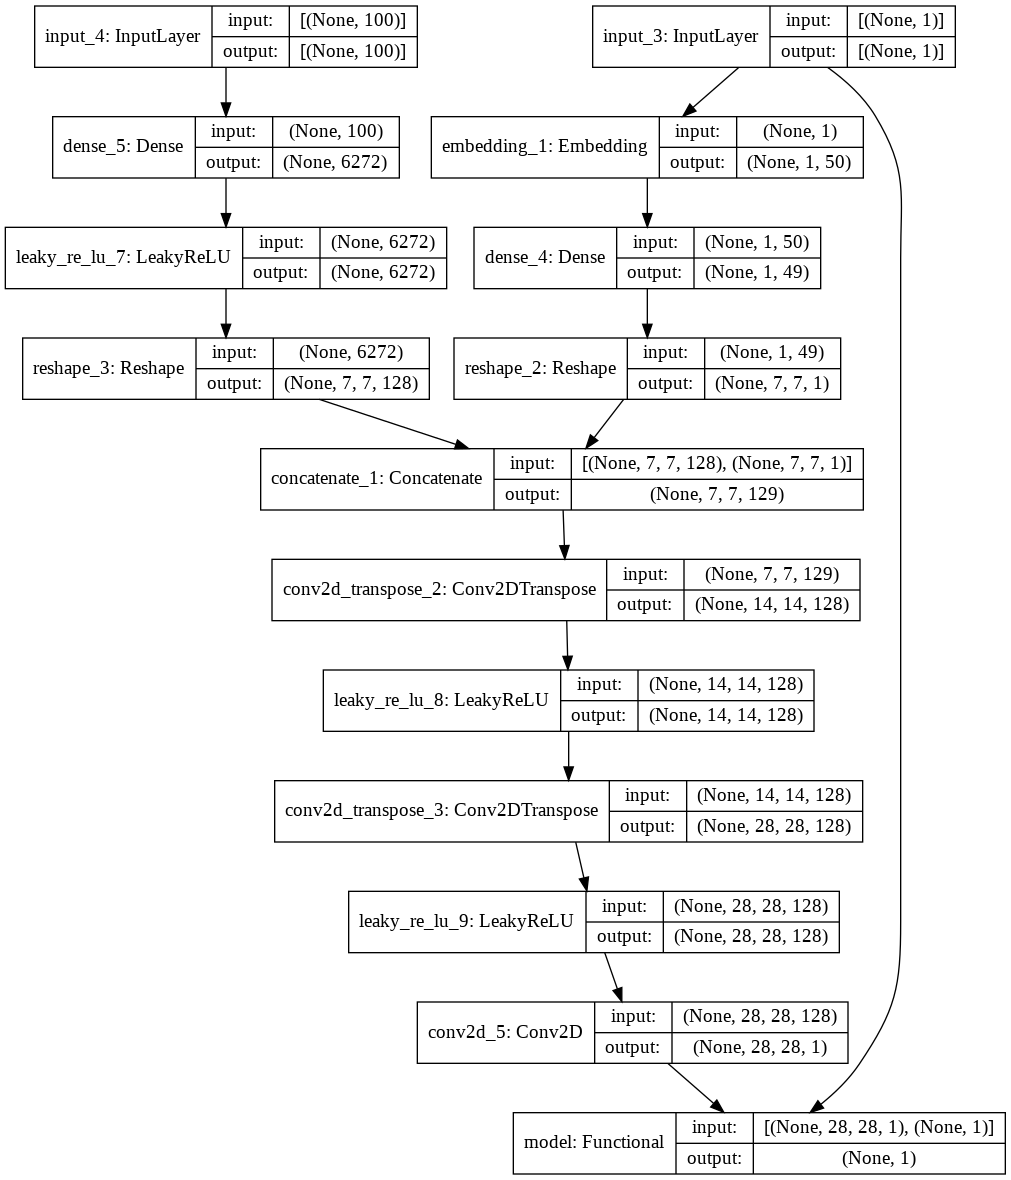

In [ ]:
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file=output_dir + "gan_model_plot.png", show_shapes=True, show_layer_names=True)

The hard part of the conversion from unconditional to conditional GAN is done, namely the definition and configuration of the model architecture. Next, all that remains is to update the training process to also use class labels. First, the ***load_real_samples()*** and ***generate_real_samples()*** functions for loading the dataset and selecting a batch of samples respectively must be updated to make use of the real class labels from the training dataset. Importantly, the ***generate_real_samples()*** function now returns images, clothing labels, and the class label for the discriminator (class = 1).

In [ ]:
# load fashion mnist images
def load_real_samples():
  # load dataset
  (trainX, trainy), (_, _) = load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype("float32")
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]

# select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y

Next, the ***generate_latent_points()*** function must be updated to also generate an array of randomly selected integer class labels to go along with the randomly selected points in the latent space. Then the ***generate_fake_samples()*** function must be updated to use these randomly generated class labels as input to the generator model when generating new fake images.

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = zeros((n_samples, 1))
  return [images, labels_input], y

Finally, the ***train()*** function must be updated to retrieve and use the class labels in the calls to updating the discriminator and generator models.

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected "real" samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate "fake" examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print(">%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f" % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save(output_dir + "cgan_generator.h5")

Tying all of this together, the complete example of a conditional deep convolutional generative adversarial network for the Fashion-MNIST dataset

In [ ]:
%%time 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>90, 151/468, d1=0.700, d2=0.683 g=0.784
>90, 152/468, d1=0.695, d2=0.679 g=0.767
>90, 153/468, d1=0.667, d2=0.664 g=0.755
>90, 154/468, d1=0.690, d2=0.694 g=0.759
>90, 155/468, d1=0.686, d2=0.699 g=0.767
>90, 156/468, d1=0.639, d2=0.661 g=0.770
>90, 157/468, d1=0.671, d2=0.661 g=0.762
>90, 158/468, d1=0.670, d2=0.648 g=0.740
>90, 159/468, d1=0.677, d2=0.659 g=0.762
>90, 160/468, d1=0.682, d2=0.685 g=0.738
>90, 161/468, d1=0.695, d2=0.675 g=0.725
>90, 162/468, d1=0.676, d2=0.697 g=0.755
>90, 163/468, d1=0.671, d2=0.687 g=0.781
>90, 164/468, d1=0.660, d2=0.699 g=0.752
>90, 165/468, d1=0.686, d2=0.747 g=0.740
>90, 166/468, d1=0.691, d2=0.677 g=0.770
>90, 167/468, d1=0.690, d2=0.663 g=0.771
>90, 168/468, d1=0.673, d2=0.689 g=0.739
>90, 169/468, d1=0.726, d2=0.670 g=0.784
>90, 170/468, d1=0.663, d2=0.661 g=0.786
>90, 171/468, d1=0.703, d2=0.669 g=0.736
>90, 172/468, d1=0.704, d2=0.670 g=0.753
>90, 173/468, d1=0.696, d2=0.679 g=0.759
>90, 1

At the end of the run, the model is saved to the file with name cgan_generator.h5.

## 5) Conditional Clothing Generation

In this section, we will use the trained generator model to conditionally generate new photos of items of clothing. We can update our code example for generating new images with the model to now generate images conditional on the class label. We can generate 10 examples for each class label in columns. The complete example is listed below.

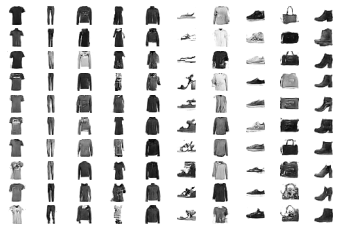

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis("off")
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap="gray_r")
  pyplot.show()
  # save plot to file
  filename = output_dir +  "cGan_generated_plot.png"
  pyplot.savefig(filename)
  pyplot.close()

# load model
model = load_model(output_dir+"cgan_generator.h5")
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

Running the example loads the saved conditional GAN model and uses it to generate 100 items of clothing. The clothing is organized in columns. From left to right, they are t-shirt, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. We can see not only are the randomly generated items of clothing plausible, but they also match their expected category.

## 7) Extensions

This section lists some ideas for extending the tutorial that you may wish to explore.
* **Latent Space Size**. Experiment by varying the size of the latent space and review the impact on the quality of generated images.
* **Embedding Size**. Experiment by varying the size of the class label embedding, making it smaller or larger, and review the impact on the quality of generated images.
* **Alternate Architecture**. Update the model architecture to concatenate the class label elsewhere in the generator and/or discriminator model, perhaps with different dimensionality, and review the impact on the quality of generated images.

In [ ]:
!cp -r /content/output "/content/drive/My Drive/Colab Notebooks/ADLCV/DAY3/output/"